# Forecast Maximum Rainfall 

## Import Packages

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import datetime
from pprint import pprint

from ts.data.dataset import PerthTempAndRainfall
from ts.utility import Utility
from ts.experimental import GeneralizedExtremeValueDistribution, GevEstimate, Pso
from ts.decompose import StlDecompose

## Load Dataset

In [35]:
rainfall_df = PerthTempAndRainfall.loadData('~/Downloads/Datasets/PerthTempAndRainfall')
rainfall_df

,Year,Month,Day,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres),Quality,Date
0,1944.0,6.0,3.0,11.0,22.3,0.0,N,1944-06-03
1,1944.0,6.0,4.0,12.2,23.4,0.0,Y,1944-06-04
2,1944.0,6.0,5.0,12.0,20.3,2.0,Y,1944-06-05
3,1944.0,6.0,6.0,7.4,18.7,3.3,Y,1944-06-06
4,1944.0,6.0,7.0,5.9,21.3,0.3,Y,1944-06-07
...,...,...,...,...,...,...,...,...
27642,1991.0,6.0,23.0,NaN,18.6,25.4,Y,None
27643,1997.0,1.0,1.0,NaN,43.5,0.0,Y,None
27644,1999.0,8.0,11.0,NaN,15.4,31.4,Y,None
27645,2018.0,5.0,26.0,NaN,18.8,27.4,N,None


In [36]:
rainfall_df.drop(range(27540, len(rainfall_df)), inplace=True)
rainfall_df.reset_index(inplace=True)
rainfall_df

,index,Year,Month,Day,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres),Quality,Date
0,0,1944.0,6.0,3.0,11.0,22.3,0.0,N,1944-06-03
1,1,1944.0,6.0,4.0,12.2,23.4,0.0,Y,1944-06-04
2,2,1944.0,6.0,5.0,12.0,20.3,2.0,Y,1944-06-05
3,3,1944.0,6.0,6.0,7.4,18.7,3.3,Y,1944-06-06
4,4,1944.0,6.0,7.0,5.9,21.3,0.3,Y,1944-06-07
...,...,...,...,...,...,...,...,...,...
27535,27535,2020.0,2.0,5.0,25.2,36.4,0.0,N,2020-02-05
27536,27536,2020.0,2.0,6.0,21.0,32.6,0.0,N,2020-02-06
27537,27537,2020.0,2.0,7.0,20.7,30.6,0.0,N,2020-02-07
27538,27538,2020.0,2.0,8.0,19.6,28.2,0.0,N,2020-02-08


In [37]:
date_series = [0] * len(rainfall_df)

for index, row in rainfall_df.iterrows():
    date_series[index] = datetime.date(
        int(row['Year']), int(row['Month']), int(row['Day'])
    )

### Plot Entire Data

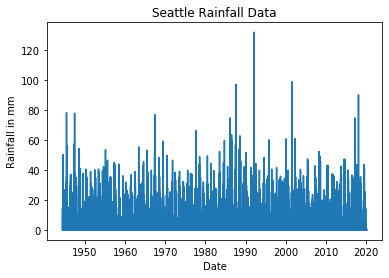

In [38]:
plt.plot(date_series, rainfall_df['Rainfall amount (millimetres)'].to_numpy())
plt.title('Seattle Rainfall Data')
plt.xlabel('Date')
plt.ylabel('Rainfall in mm')
plt.show()

## Computing Monthly Max Rainfall

Data Type: float64, Data Shape: (909,)

First 10 data points:
[19.3, 41.4, 50.3, 14.5, 9.9, 14.7, 26.7, 1.0, 2.0, 14.5]

Last 10 data points:
[5.8, 43.8, 41.4, 25.4, 17.6, 9.0, 14.4, 1.8, 0.6, 0.0]


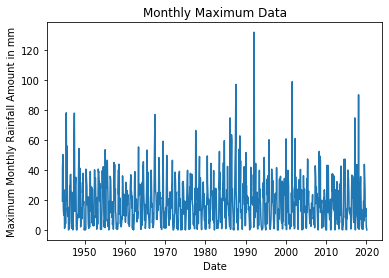

In [40]:
month_max_series = [rainfall_df.iloc[0]['Rainfall amount (millimetres)']]
month_date_series = [date_series[0]]

for index, row in rainfall_df.iloc[1:].iterrows():
    
    if date_series[index].month == date_series[index - 1].month:
        if month_max_series[-1] < row['Rainfall amount (millimetres)']:
            month_max_series[-1] = row['Rainfall amount (millimetres)']
            month_date_series[-1] = date_series[index]
        
    else:
        month_max_series.append(row['Rainfall amount (millimetres)'])
        month_date_series.append(date_series[index])
    
month_max_series = np.array(month_max_series)

print(f'Data Type: {month_max_series.dtype}, Data Shape: {month_max_series.shape}\n')
print('First 10 data points:')
pprint(list(month_max_series[:10]))
print('')

print('Last 10 data points:')
pprint(list(month_max_series[-10:]))

plt.plot(month_date_series, month_max_series)
plt.title('Monthly Maximum Data')
plt.xlabel('Date')
plt.ylabel('Maximum Monthly Rainfall Amount in mm')
plt.show()

In [41]:
train_frac = 0.90
n = month_max_series.shape[0]
num_train = int(n * train_frac)

print(f'Train Size: {num_train}, Test Size: {n - num_train}')

Train Size: 818, Test Size: 91


## Decompose the time series into trend, seasonality and remainder components

In [42]:
trend_series, seasonality_series, remainder_series = StlDecompose\
    .decompose(np.expand_dims(month_max_series, axis=1), 
        period=12, seasonal=101, robust=True)

assert trend_series.shape == seasonality_series.shape == remainder_series.shape

In [43]:
trend_series_train = trend_series[:num_train]
seasonality_series_train = seasonality_series[:num_train]
remainder_series_train = remainder_series[:num_train]

### Plot Time Series Components

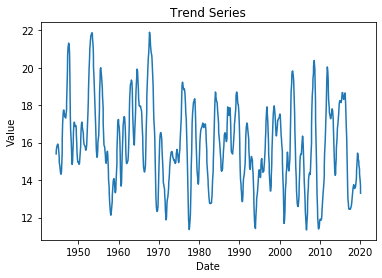

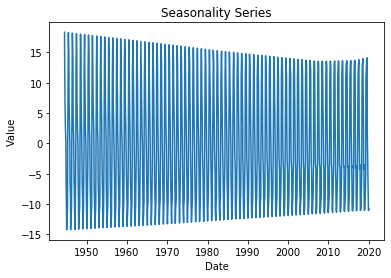

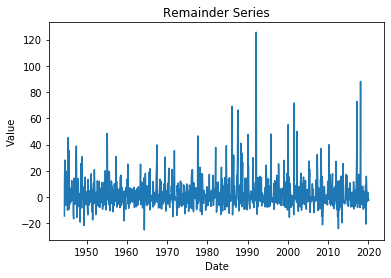

In [44]:
plt.plot(month_date_series, trend_series)
plt.title('Trend Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

plt.plot(month_date_series, seasonality_series)
plt.title('Seasonality Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

plt.plot(month_date_series, remainder_series)
plt.title('Remainder Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

### Compare the inferred seasonality with actual data

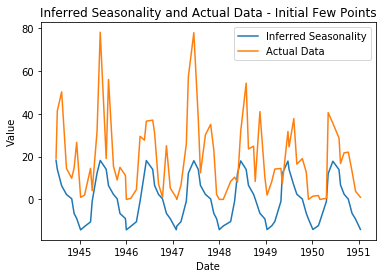

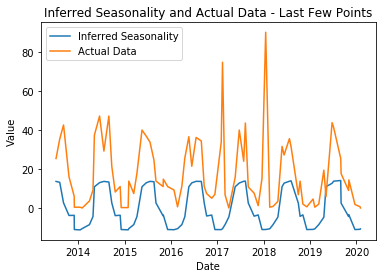

In [45]:
# Front Few Points
num_initial_points = 80

plt.plot(
    month_date_series[:num_initial_points],
    seasonality_series[:num_initial_points], 
    label='Inferred Seasonality'
)
plt.plot(
    month_date_series[:num_initial_points],
    month_max_series[:num_initial_points], 
    label='Actual Data'
)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Initial Few Points')
plt.show()

# Last Few Points
num_last_points = 80

plt.plot(
    month_date_series[-num_last_points:],
    seasonality_series[-num_last_points:], 
    label='Inferred Seasonality'
)
plt.plot(
    month_date_series[-num_last_points:],
    month_max_series[-num_last_points:], 
    label='Actual Data'
)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Last Few Points')
plt.show()

## Parameter Estimation of GEV fitted to Remainder Series

### Fitting GEV parameters using PSO to remainder series

Shape Parameter: 0.02269073013407803 
Location Parameter: -2.518160099887233 
Scale Parameter: 8.281311603813679 
Log Likelihood: -3017.047502041357


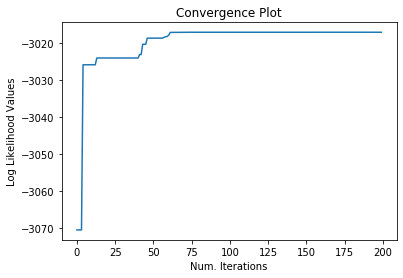

In [46]:
params, max_log_likelihood, max_log_likelihood_vals = GevEstimate.psoMethod(
    remainder_series[:num_train],
    Pso.computeInitialPos([(-10, 10), (-10, 10), (5, 30)], 200),
    numIterations=200
)

shape, location, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Location Parameter: {location} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

In [47]:
gev_dist = GeneralizedExtremeValueDistribution(*tuple(params))

### Plot PDF and CDF

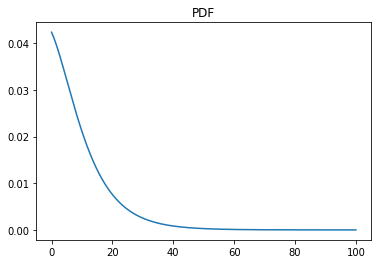

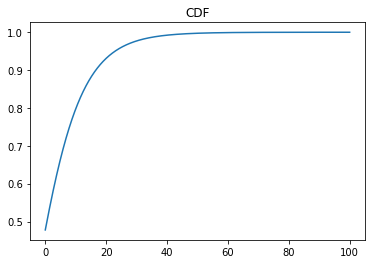

In [49]:
x = np.linspace(0, 100, 10000)

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).pdf(x)
)
plt.title('PDF')
plt.show()

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).cdf(x)
)
plt.title('CDF')
plt.show()

## Compute CDF of each data point in remainder series

Data Type: float64, Data Shape: (909, 1)

First 5 data points:
array([[0.01344547],
       [0.83120109],
       [0.97193289],
       [0.31843232],
       [0.2044801 ]])

Last 5 data points:
array([[0.42546073],
       [0.61679678],
       [0.42776402],
       [0.38424722],
       [0.36603355]])


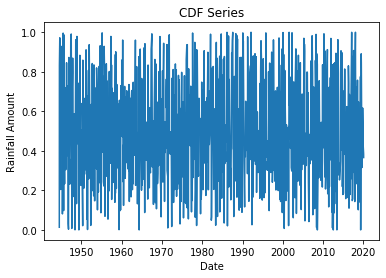

In [50]:
remainder_series_cdf = gev_dist.cdf(remainder_series)

print(f'Data Type: {remainder_series_cdf.dtype}, Data Shape: {remainder_series_cdf.shape}\n')
print('First 5 data points:')
pprint(remainder_series_cdf[:5])
print('')

print('Last 5 data points:')
pprint(remainder_series_cdf[-5:])

plt.plot(month_date_series, remainder_series_cdf)
plt.title('CDF Series')
plt.xlabel('Date')
plt.ylabel('Rainfall Amount')
plt.show()

## Model for Forecasting next day CDF

### Model Architecture

In [94]:
lag = 20

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, lag))
model.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.005, 40, 0.99
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Train the model

In [95]:
input_data = []
output_data = []

for i in range(lag, num_train):
    input_data.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    output_data.append(remainder_series_cdf[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (798, 20)
Output Data Shape: (798, 1)


Epoch 1/200
25/25 [==============================] - 0s 691us/step - loss: 0.0698
Epoch 2/200
25/25 [==============================] - 0s 989us/step - loss: 0.0691
Epoch 3/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0683
Epoch 4/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0683
Epoch 5/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0676
Epoch 6/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0668
Epoch 7/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0660
Epoch 8/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0655
Epoch 9/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0647
Epoch 10/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0635
Epoch 11/200
25/25 [==============================] - 0s 835us/step - loss: 0.0631
Epoch 12/200
25/25 [==============================] - 0s 785us/step - loss: 0.0631
Epoch 13/200
25/25 [=========

25/25 [==============================] - 0s 767us/step - loss: 0.0188
Epoch 101/200
25/25 [==============================] - 0s 919us/step - loss: 0.0176
Epoch 102/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0180
Epoch 103/200
25/25 [==============================] - 0s 864us/step - loss: 0.0172
Epoch 104/200
25/25 [==============================] - 0s 749us/step - loss: 0.0166
Epoch 105/200
25/25 [==============================] - 0s 708us/step - loss: 0.0175
Epoch 106/200
25/25 [==============================] - 0s 738us/step - loss: 0.0167
Epoch 107/200
25/25 [==============================] - 0s 652us/step - loss: 0.0162
Epoch 108/200
25/25 [==============================] - 0s 845us/step - loss: 0.0165
Epoch 109/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0162
Epoch 110/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0159
Epoch 111/200
25/25 [==============================] - 0s 861us/step - loss: 0.0150
Epoch 112/20

25/25 [==============================] - 0s 686us/step - loss: 0.0067
Epoch 198/200
25/25 [==============================] - 0s 676us/step - loss: 0.0073
Epoch 199/200
25/25 [==============================] - 0s 633us/step - loss: 0.0071
Epoch 200/200
25/25 [==============================] - 0s 714us/step - loss: 0.0068


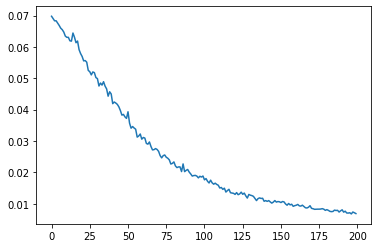

In [96]:
history = model.fit(input_data, output_data, epochs=200)
plt.plot(history.history['loss'])

### Forecast training data

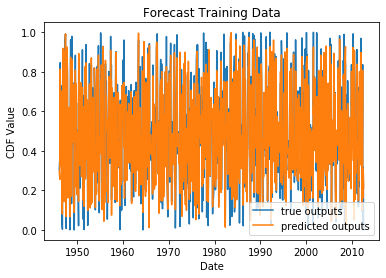

In [97]:
remainder_train_cdf = model.predict(input_data)
remainder_train = gev_dist.computeQuantile(remainder_train_cdf)

plt.plot(
    month_date_series[lag: num_train], 
    output_data, 
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train], 
    remainder_train_cdf, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('CDF Value')
plt.legend()
plt.title('Forecast Training Data')
plt.show()

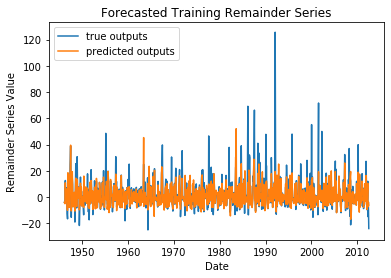

In [98]:
plt.plot(
    month_date_series[lag: num_train],
    remainder_series[lag: num_train],
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train], 
    remainder_train, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Remainder Series Value')
plt.legend()
plt.title('Forecasted Training Remainder Series')
plt.show()

### Forecast test data

In [99]:
test_input = []
test_output = []

for i in range(num_train, n):
    test_input.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    test_output.append(remainder_series_cdf[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

Test Input Data Shape: (91, 20)
Test Output Data Shape: (91, 1)


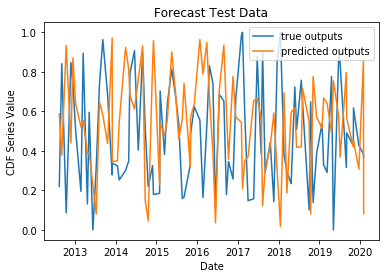

In [100]:
remainder_test_cdf = model.predict(test_input)
remainder_test = gev_dist.computeQuantile(remainder_test_cdf)

plt.plot(
    month_date_series[num_train:],
    test_output, 
    label='true outputs'
)
plt.plot(
    month_date_series[num_train:],
    remainder_test_cdf, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('CDF Series Value')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

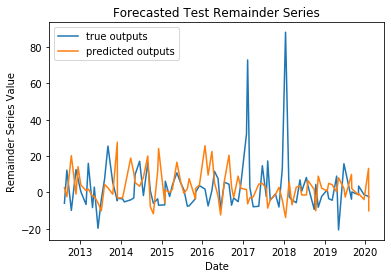

In [101]:
plt.plot(
    month_date_series[num_train:],
    remainder_series[num_train:], 
    label='true outputs'
)
plt.plot(
    month_date_series[num_train:],
    remainder_test, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Remainder Series Value')
plt.legend()
plt.title('Forecasted Test Remainder Series')
plt.show()

## Forecasting Trend

### Model Architecture

In [102]:
model_trend = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation=None)
])

model_trend.build(input_shape=(None, lag))
model_trend.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Train the model

In [103]:
input_data = []
output_data = []

for i in range(lag, num_train):
    input_data.append(np.squeeze(trend_series[i - lag:i], axis=1))
    output_data.append(trend_series[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (798, 20)
Output Data Shape: (798, 1)


Epoch 1/100
25/25 [==============================] - 0s 847us/step - loss: 20.6239
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 5.6352
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 5.3312
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 4.1953
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 3.5368
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 3.1212
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 2.5984
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 2.1354
Epoch 9/100
25/25 [==============================] - 0s 1ms/step - loss: 1.5401
Epoch 10/100
25/25 [==============================] - 0s 1ms/step - loss: 1.0870
Epoch 11/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9836
Epoch 12/100
25/25 [==============================] - 0s 1ms/step - loss: 0.9210
Epoch 13/100
25/25 [==============

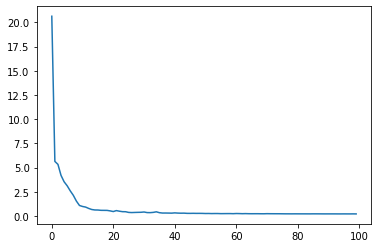

In [104]:
history = model_trend.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Forecast training data

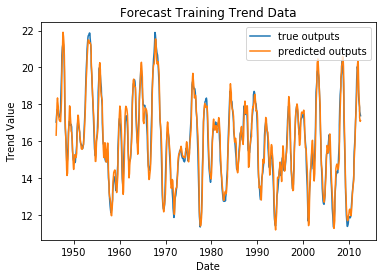

In [105]:
trend_train = model_trend.predict(input_data)

plt.plot(
    month_date_series[lag: num_train],
    output_data, 
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train],
    trend_train, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.title('Forecast Training Trend Data')
plt.show()

### Forecast test data

In [106]:
test_input = []
test_output = []

for i in range(num_train, n):
    test_input.append(np.squeeze(trend_series[i - lag:i], axis=1))
    test_output.append(trend_series[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

Test Input Data Shape: (91, 20)
Test Output Data Shape: (91, 1)


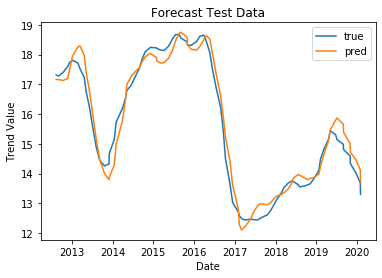

In [107]:
trend_test = model_trend.predict(test_input)

plt.plot(
    month_date_series[num_train:], 
    test_output, 
    label='true'
)
plt.plot(
    month_date_series[num_train:], 
    trend_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

## Forecasting Seasonality

### Forecast training data

In [108]:
seasonality_train = seasonality_series[:num_train][lag:]

### Forecast test data

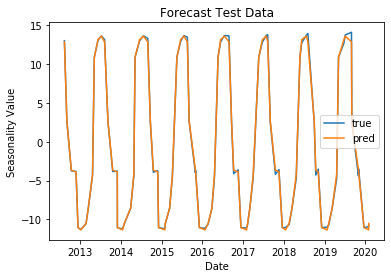

In [109]:
season_values = seasonality_series[:num_train][-12:]
seasonality_test = np.zeros((n - num_train, 1))

for i in range(n - num_train):
    seasonality_test[i] = season_values[i % 12]
    
plt.plot(
    month_date_series[num_train:],
    seasonality_series[num_train:], 
    label='true'
)
plt.plot(
    month_date_series[num_train:],
    seasonality_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Seasonality Value')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

## Forecast Maximum Rainfall

In [110]:
print(remainder_train.shape, trend_train.shape, seasonality_train.shape)
print(remainder_test.shape, trend_test.shape, seasonality_test.shape)

(798, 1) (798, 1) (798, 1)
(91, 1) (91, 1) (91, 1)


### Forecast training data

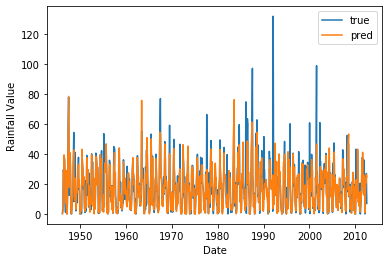

In [111]:
pred_train = np.maximum(remainder_train + trend_train + seasonality_train, 0)
true_train = month_max_series[:num_train][lag:]

plt.plot(
    month_date_series[lag: num_train],
    true_train, 
    label='true'
)
plt.plot(
    month_date_series[lag: num_train],
    pred_train, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.legend()
plt.show()

### Forecast test data

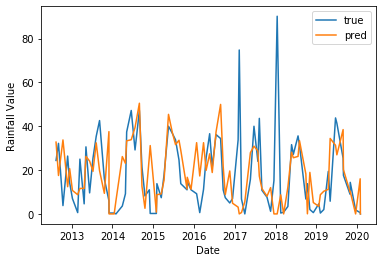

In [112]:
pred_test = np.maximum(remainder_test + trend_test + seasonality_test, 0)
true_test = month_max_series[num_train:]

plt.plot(
    month_date_series[num_train:],
    true_test, 
    label='true'
)
plt.plot(
    month_date_series[num_train:],
    pred_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.legend()
plt.show()